# Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import re
import sys

import time
import torch
import torch.hub
import torch.nn

import random

from pred_utils import balanced_over_sampling

In [2]:
if torch.cuda.is_available():
    device = "cuda:0"  ###### "cuda: 1"
else:
    device = "cpu"

In [3]:
gut_16s_df = pd.read_table("./data/gut_16s_abundance.txt", index_col=0)
metabolome_df = pd.read_table("./data/metabolome_abundance.txt", index_col=0)
metabolome_df = metabolome_df.drop(columns=['SubjectID', 'CollectionDate', 'CL1', 'CL2', 'CL3', 'CL4'])
subjects = pd.read_csv("./data/subjects.csv", na_values="NA")

In [4]:
from sklearn.preprocessing import StandardScaler
gut_16s_df_array = StandardScaler().fit_transform(gut_16s_df)
gut_16s_df = pd.DataFrame(gut_16s_df_array, index=gut_16s_df.index, columns=gut_16s_df.columns)

metabolome_df_array = StandardScaler().fit_transform(metabolome_df)
metabolome_df = pd.DataFrame(metabolome_df_array, index=metabolome_df.index, columns=metabolome_df.columns)

## Build MLPs

In [5]:
### some parameters used in models
n_out_features = 10

# Training parameters
# Decreasing lr and adding gradient_clip improves stability
lr = 0.001
momentum = 0.9
weight_decay_dict = dict([('IR_IS_classification', 0.01), ('Sex', 0.01), ('Race', 0.01)])
gradient_clip = 3

dropout_dict = dict([('IR_IS_classification', 0.6), ('Sex', 0.6), ('Race', 0.4)])

In [6]:
import torch
import torch.nn as nn
class Classifier(torch.nn.Module):
    def __init__(self, net_structure, n_out_features, label_dim, dropout_rate):
        super(Classifier, self).__init__()
        genenet_fcs = []
        structure = net_structure
        genenet_in_shape = structure[0]
        for i, genenet_n_hidden_nodes in enumerate(structure[1:]):
            genenet_fcs.append(torch.nn.Linear(genenet_in_shape, genenet_n_hidden_nodes))
            genenet_fcs.append(torch.nn.BatchNorm1d(genenet_n_hidden_nodes))
            genenet_fcs.append(torch.nn.ReLU6())
            genenet_fcs.append(torch.nn.Dropout(p=dropout_rate))
            genenet_in_shape = genenet_n_hidden_nodes
        genenet_fcs.append(torch.nn.Linear(genenet_in_shape, n_out_features))
        genenet_fcs.append(torch.nn.Linear(n_out_features, label_dim))
        self.genenet_fcs = torch.nn.ModuleList(genenet_fcs)
        
    def forward(self, x):
        genenet_fcs = self.genenet_fcs
        for genenet_fc in genenet_fcs:
            x = genenet_fc(x)
        return x

In [7]:
# train function
from utils_eval import AverageMeter

def train(epoch, classifier, criterion, optimizer, train_loader, device='cuda:0'):
    """
    One epoch training
    """
    
    classifier.train()
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # ===================forward=====================
        outputs = classifier(data)
        loss = criterion(outputs, target)

        # ===================backward=====================
        loss.backward()
        optimizer.step()
    
    return loss

In [8]:
def train_mlp(covariate, gm_data_name, batch_size = 32, n_epoch=500, random_seed=456):
    
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    random.seed(random_seed)
    #torch.set_deterministic(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(random_seed)
        
    from pred_utils import balanced_over_sampling
    gut_16s_feat_subj_all = pd.read_pickle('./feature_data/{}/all/gut_16s_feat_subj_all.pkl'.format(covariate))
    
    gut_16s_feat_subj_train = pd.read_pickle('./feature_data/{}/train/gut_16s_feat_subj_train.pkl'.format(covariate))
    metabolome_feat_subj_train = pd.read_pickle('./feature_data/{}/train/metabolome_feat_subj_train.pkl'.format(covariate))

    gut_16s_feat_subj_val = pd.read_pickle('./feature_data/{}/val/gut_16s_feat_subj_val.pkl'.format(covariate))
    metabolome_feat_subj_val = pd.read_pickle('./feature_data/{}/val/metabolome_feat_subj_val.pkl'.format(covariate))

    gut_16s_feat_subj_test = pd.read_pickle('./feature_data/{}/test/gut_16s_feat_subj_test.pkl'.format(covariate))
    metabolome_feat_subj_test = pd.read_pickle('./feature_data/{}/test/metabolome_feat_subj_test.pkl'.format(covariate))
    
    indexes_noukn = gut_16s_feat_subj_all.index
    indexes_train = gut_16s_feat_subj_train.index
    indexes_val = gut_16s_feat_subj_val.index
    indexes_test = gut_16s_feat_subj_test.index

    X_train_g = np.array(gut_16s_df.loc[indexes_train,:])
    y_train_g = gut_16s_feat_subj_train.loc[:,covariate].values
    X_val_g = np.array(gut_16s_df.loc[indexes_val,:])
    y_val_g = gut_16s_feat_subj_val.loc[:,covariate].values
    X_test_g = np.array(gut_16s_df.loc[indexes_test,:])
    y_test_g = gut_16s_feat_subj_test.loc[:,covariate].values

    X_train_m = np.array(metabolome_df.loc[indexes_train,:])
    y_train_m = metabolome_feat_subj_train.loc[:,covariate].values
    X_val_m = np.array(metabolome_df.loc[indexes_val,:])
    y_val_m = metabolome_feat_subj_val.loc[:,covariate].values
    X_test_m = np.array(metabolome_df.loc[indexes_test,:])
    y_test_m = metabolome_feat_subj_test.loc[:,covariate].values

    if gm_data_name=='gut_16s':
        X_train, X_val, X_test, y_train, y_val, y_test = X_train_g, X_val_g, X_test_g, y_train_g, y_val_g, y_test_g
        net_structure = [gut_16s_df.shape[1], 64, 32]
    
    elif gm_data_name=='metabolome':
        X_train, X_val, X_test, y_train, y_val, y_test = X_train_m, X_val_m, X_test_m, y_train_m, y_val_m, y_test_m
        net_structure = [metabolome_df.shape[1], 256, 64]
        
    X_balanced_train, y_balanced_train = balanced_over_sampling(X_train, y_train)

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    le.fit(gut_16s_feat_subj_all[covariate])
    y_balanced_train_le = le.transform(y_balanced_train)
    y_val_le = le.transform(y_val)
    y_test_le = le.transform(y_test)
    classes = le.classes_
    label_dim = len(classes)

    train_data = torch.utils.data.TensorDataset(torch.tensor(np.array(X_balanced_train, dtype='float32')), 
                                                torch.LongTensor(y_balanced_train_le))
    val_data = torch.utils.data.TensorDataset(torch.tensor(np.array(X_val, dtype='float32')), 
                                              torch.LongTensor(y_val_le))

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=0)
    classifier = Classifier(net_structure = net_structure, n_out_features=n_out_features, 
                            label_dim=label_dim, dropout_rate=dropout_dict[covariate]).to(device)
    criterion = nn.CrossEntropyLoss() # nn.CrossEntropyLoss combines log_softmax and NLLLoss
    optimizer = torch.optim.SGD(classifier.parameters(), lr=lr, momentum=momentum, 
                                  weight_decay = weight_decay_dict[covariate])
    
    # trian
    # =========================
    hist = dict()
    hist['train_loss'] = []
    hist['val_loss'] = []

    for epoch in range(n_epoch):
        # Train
        train_loss = \
            train(epoch, classifier, criterion, optimizer, train_loader, device=device)
        hist['train_loss'].append(train_loss.cpu().detach().numpy())

        # Val
        classifier.eval()

        with torch.no_grad():
            for idx, (data, target) in enumerate(val_loader):
                data, target = data.to(device), target.to(device)

                # ===================forward=====================
                outputs = classifier(data)
                val_loss = criterion(outputs, target)

            hist['val_loss'].append(val_loss.cpu().detach().numpy())
        print('Epoch {} \ttrain_loss\t{}\tval_loss\t{}'.format(epoch, train_loss, val_loss))

    os.makedirs('./models/MLP_random_seed_{}/{}'.format(random_seed, gm_data_name), exist_ok=True)
    
    torch.save({
                'epoch': n_epoch,
                'model_state_dict': classifier.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': hist
                }, './models/MLP_random_seed_{}/{}/model_{}.pth'.format(random_seed, gm_data_name, covariate))
    return classifier, optimizer, hist, (indexes_noukn, indexes_train, indexes_val, indexes_test), le

In [9]:
def plot_mlp_loss(hist, covariate, gm_data_name, random_seed=456):

    fig = plt.figure(figsize=(16,8))

    plt.plot(np.arange(len(hist['train_loss'])), hist['train_loss'], 
                 label='Training loss', alpha=0.8)

    plt.plot(np.arange(len(hist['val_loss'])), hist['val_loss'], 
                 label='Validation loss', alpha=0.8)

    plt.xlabel('Epoches', fontsize=20)
    plt.xticks(fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.yticks(fontsize=20)
    plt.title('MLP Loss for {} (Covariate = {})'.format(gm_data_name, covariate), fontsize=20)
    plt.legend(fontsize=20)
    
    save_folder = './figures/MLP_random_seed_{}/{}/{}'.format(random_seed, gm_data_name, covariate)
    os.makedirs(save_folder, exist_ok=True)
    fig.savefig(os.path.join(save_folder, 'MLP_train_val_losses.pdf'))
    plt.show()

## Train and forward

### 1) IR_IS_classification

In [10]:
classifier_g_iris, optimizer_g_iris, hist_g_iris, index_set_iris, le_iris =\
    train_mlp('IR_IS_classification', 'gut_16s', random_seed=456)

Epoch 0 	train_loss	0.7052316665649414	val_loss	0.6826919317245483
Epoch 1 	train_loss	0.8243811130523682	val_loss	0.681651771068573
Epoch 2 	train_loss	0.6961562633514404	val_loss	0.6765129566192627
Epoch 3 	train_loss	0.6646121740341187	val_loss	0.6747285723686218
Epoch 4 	train_loss	0.708284318447113	val_loss	0.6723415851593018
Epoch 5 	train_loss	0.7554817795753479	val_loss	0.6689358949661255
Epoch 6 	train_loss	0.7496737837791443	val_loss	0.6679089069366455
Epoch 7 	train_loss	0.7116155624389648	val_loss	0.6702346205711365
Epoch 8 	train_loss	0.6740279793739319	val_loss	0.6693663001060486
Epoch 9 	train_loss	0.6513816118240356	val_loss	0.6694504618644714
Epoch 10 	train_loss	0.7701411843299866	val_loss	0.6679379343986511
Epoch 11 	train_loss	0.7404642701148987	val_loss	0.6675921082496643
Epoch 12 	train_loss	0.6849300265312195	val_loss	0.6648250818252563
Epoch 13 	train_loss	0.7186179161071777	val_loss	0.661179780960083
Epoch 14 	train_loss	0.6600838303565979	val_loss	0.6606155037

Epoch 123 	train_loss	0.3435858488082886	val_loss	0.37403225898742676
Epoch 124 	train_loss	0.35579851269721985	val_loss	0.36368560791015625
Epoch 125 	train_loss	0.25954750180244446	val_loss	0.36616626381874084
Epoch 126 	train_loss	0.4938955307006836	val_loss	0.36666619777679443
Epoch 127 	train_loss	0.6354972720146179	val_loss	0.36379554867744446
Epoch 128 	train_loss	0.41763588786125183	val_loss	0.36770471930503845
Epoch 129 	train_loss	0.23168165981769562	val_loss	0.3655727803707123
Epoch 130 	train_loss	0.32325974106788635	val_loss	0.3650413751602173
Epoch 131 	train_loss	0.3230719566345215	val_loss	0.36446696519851685
Epoch 132 	train_loss	0.20481902360916138	val_loss	0.36683833599090576
Epoch 133 	train_loss	0.32578375935554504	val_loss	0.3670608699321747
Epoch 134 	train_loss	0.45371028780937195	val_loss	0.36163651943206787
Epoch 135 	train_loss	0.33297666907310486	val_loss	0.36491432785987854
Epoch 136 	train_loss	0.29555732011795044	val_loss	0.367879182100296
Epoch 137 	trai

Epoch 245 	train_loss	0.24431227147579193	val_loss	0.3559814989566803
Epoch 246 	train_loss	0.1342639923095703	val_loss	0.3495512306690216
Epoch 247 	train_loss	0.31307849287986755	val_loss	0.3568246066570282
Epoch 248 	train_loss	0.4577280282974243	val_loss	0.36050713062286377
Epoch 249 	train_loss	0.23121607303619385	val_loss	0.3617035150527954
Epoch 250 	train_loss	0.14659297466278076	val_loss	0.3588353395462036
Epoch 251 	train_loss	0.7255428433418274	val_loss	0.36196979880332947
Epoch 252 	train_loss	0.7273344397544861	val_loss	0.35961294174194336
Epoch 253 	train_loss	0.18984825909137726	val_loss	0.35090985894203186
Epoch 254 	train_loss	0.2537158727645874	val_loss	0.34742361307144165
Epoch 255 	train_loss	0.5682450532913208	val_loss	0.346227765083313
Epoch 256 	train_loss	0.1900184154510498	val_loss	0.34548434615135193
Epoch 257 	train_loss	0.1127156913280487	val_loss	0.34952929615974426
Epoch 258 	train_loss	0.6254736185073853	val_loss	0.3426118493080139
Epoch 259 	train_loss	0

Epoch 364 	train_loss	0.0839882418513298	val_loss	0.354763388633728
Epoch 365 	train_loss	0.2308056801557541	val_loss	0.35523521900177
Epoch 366 	train_loss	0.7441044449806213	val_loss	0.3506089448928833
Epoch 367 	train_loss	0.12002387642860413	val_loss	0.354110449552536
Epoch 368 	train_loss	0.4301290810108185	val_loss	0.3451617658138275
Epoch 369 	train_loss	0.34354230761528015	val_loss	0.3591375946998596
Epoch 370 	train_loss	0.3825831413269043	val_loss	0.35013821721076965
Epoch 371 	train_loss	1.2095569372177124	val_loss	0.39012160897254944
Epoch 372 	train_loss	0.2690871059894562	val_loss	0.3686792552471161
Epoch 373 	train_loss	0.16214200854301453	val_loss	0.35781586170196533
Epoch 374 	train_loss	0.25002381205558777	val_loss	0.3704163730144501
Epoch 375 	train_loss	0.8041257262229919	val_loss	0.34016385674476624
Epoch 376 	train_loss	0.5733481645584106	val_loss	0.3412512242794037
Epoch 377 	train_loss	0.19072294235229492	val_loss	0.35346344113349915
Epoch 378 	train_loss	0.4067

Epoch 484 	train_loss	0.5892048478126526	val_loss	0.38665199279785156
Epoch 485 	train_loss	0.2853362560272217	val_loss	0.3998129665851593
Epoch 486 	train_loss	0.27137038111686707	val_loss	0.4017356336116791
Epoch 487 	train_loss	0.09860054403543472	val_loss	0.37168776988983154
Epoch 488 	train_loss	0.11707532405853271	val_loss	0.38516801595687866
Epoch 489 	train_loss	0.28146418929100037	val_loss	0.36240026354789734
Epoch 490 	train_loss	0.19216491281986237	val_loss	0.3678317666053772
Epoch 491 	train_loss	0.10169792920351028	val_loss	0.3588561713695526
Epoch 492 	train_loss	0.521181046962738	val_loss	0.3607616722583771
Epoch 493 	train_loss	0.10173357278108597	val_loss	0.3507276773452759
Epoch 494 	train_loss	0.17428922653198242	val_loss	0.3276347219944
Epoch 495 	train_loss	0.12679018080234528	val_loss	0.3418176472187042
Epoch 496 	train_loss	0.2461717575788498	val_loss	0.35801440477371216
Epoch 497 	train_loss	0.24160949885845184	val_loss	0.3617407977581024
Epoch 498 	train_loss	0

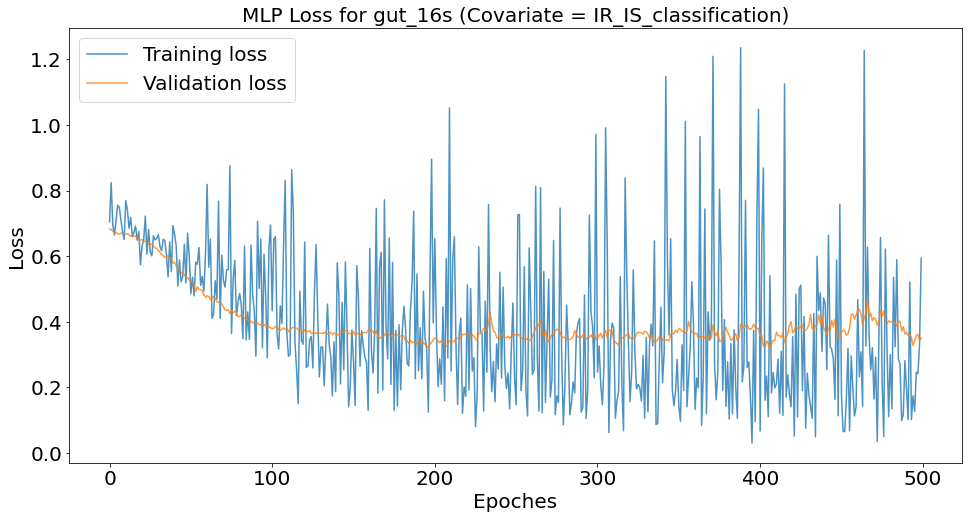

In [11]:
plot_mlp_loss(hist_g_iris, 'IR_IS_classification', 'gut_16s', random_seed=456)

In [12]:
classifier_m_iris, optimizer_m_iris, hist_m_iris, index_set_iris, le_iris =\
    train_mlp('IR_IS_classification', 'metabolome', random_seed=456)

Epoch 0 	train_loss	0.7942121624946594	val_loss	0.7213810086250305
Epoch 1 	train_loss	0.7306286692619324	val_loss	0.7134521007537842
Epoch 2 	train_loss	0.7199104428291321	val_loss	0.6966907978057861
Epoch 3 	train_loss	0.6577062010765076	val_loss	0.6836695671081543
Epoch 4 	train_loss	0.6443188786506653	val_loss	0.6614502668380737
Epoch 5 	train_loss	0.552535355091095	val_loss	0.6505357623100281
Epoch 6 	train_loss	0.6191765666007996	val_loss	0.631534993648529
Epoch 7 	train_loss	0.5643206238746643	val_loss	0.6157533526420593
Epoch 8 	train_loss	0.35096392035484314	val_loss	0.6000533699989319
Epoch 9 	train_loss	0.59486323595047	val_loss	0.5795007348060608
Epoch 10 	train_loss	0.5120634436607361	val_loss	0.5648513436317444
Epoch 11 	train_loss	0.5997937321662903	val_loss	0.5487208962440491
Epoch 12 	train_loss	0.4517468214035034	val_loss	0.520400881767273
Epoch 13 	train_loss	0.3918858468532562	val_loss	0.5105751156806946
Epoch 14 	train_loss	0.4967000484466553	val_loss	0.49976858496

Epoch 119 	train_loss	0.279220849275589	val_loss	0.1302296370267868
Epoch 120 	train_loss	0.03757673501968384	val_loss	0.08570596575737
Epoch 121 	train_loss	0.044520776718854904	val_loss	0.11534750461578369
Epoch 122 	train_loss	0.02664707601070404	val_loss	0.1204947903752327
Epoch 123 	train_loss	0.01566118560731411	val_loss	0.11829348653554916
Epoch 124 	train_loss	0.0011646004859358072	val_loss	0.12518103420734406
Epoch 125 	train_loss	0.019915616139769554	val_loss	0.11763637512922287
Epoch 126 	train_loss	0.0011071296175941825	val_loss	0.12691731750965118
Epoch 127 	train_loss	0.08604650944471359	val_loss	0.1211571991443634
Epoch 128 	train_loss	0.15066276490688324	val_loss	0.1348617672920227
Epoch 129 	train_loss	0.009783693589270115	val_loss	0.11907128244638443
Epoch 130 	train_loss	0.2955387532711029	val_loss	0.12236209958791733
Epoch 131 	train_loss	0.18484552204608917	val_loss	0.1189068928360939
Epoch 132 	train_loss	0.007796345744282007	val_loss	0.11592593789100647
Epoch 133

Epoch 234 	train_loss	0.00877650361508131	val_loss	0.11389544606208801
Epoch 235 	train_loss	0.010529995895922184	val_loss	0.09938803315162659
Epoch 236 	train_loss	0.006734089460223913	val_loss	0.09514512121677399
Epoch 237 	train_loss	0.0006365123554132879	val_loss	0.09673825651407242
Epoch 238 	train_loss	0.01736822910606861	val_loss	0.11830290406942368
Epoch 239 	train_loss	0.011708158068358898	val_loss	0.0776960700750351
Epoch 240 	train_loss	0.003524618921801448	val_loss	0.09294939041137695
Epoch 241 	train_loss	0.013209822587668896	val_loss	0.0866636261343956
Epoch 242 	train_loss	0.0012740710517391562	val_loss	0.1313813328742981
Epoch 243 	train_loss	0.003437955165281892	val_loss	0.10726311057806015
Epoch 244 	train_loss	0.24920673668384552	val_loss	0.07209893316030502
Epoch 245 	train_loss	0.004630676936358213	val_loss	0.10028377920389175
Epoch 246 	train_loss	0.03079608641564846	val_loss	0.10358992218971252
Epoch 247 	train_loss	0.022293491289019585	val_loss	0.105685353279113

Epoch 349 	train_loss	0.01730484329164028	val_loss	0.09893710166215897
Epoch 350 	train_loss	0.025296831503510475	val_loss	0.059052448719739914
Epoch 351 	train_loss	0.0454937107861042	val_loss	0.07566807419061661
Epoch 352 	train_loss	0.006337522994726896	val_loss	0.08571052551269531
Epoch 353 	train_loss	0.0020885237026959658	val_loss	0.10298134386539459
Epoch 354 	train_loss	0.0018499827710911632	val_loss	0.10012387484312057
Epoch 355 	train_loss	0.004277083091437817	val_loss	0.09134955704212189
Epoch 356 	train_loss	0.026148216798901558	val_loss	0.08743235468864441
Epoch 357 	train_loss	0.01730002462863922	val_loss	0.09494435042142868
Epoch 358 	train_loss	0.0038289781659841537	val_loss	0.11253871023654938
Epoch 359 	train_loss	0.002633820055052638	val_loss	0.10484696924686432
Epoch 360 	train_loss	0.016690436750650406	val_loss	0.11623997241258621
Epoch 361 	train_loss	0.002166817197576165	val_loss	0.11353000998497009
Epoch 362 	train_loss	0.002148713218048215	val_loss	0.1068739816

Epoch 464 	train_loss	0.18926578760147095	val_loss	0.061888840049505234
Epoch 465 	train_loss	0.01272407453507185	val_loss	0.07615124434232712
Epoch 466 	train_loss	0.04982532188296318	val_loss	0.09300465136766434
Epoch 467 	train_loss	0.011414154432713985	val_loss	0.07575105875730515
Epoch 468 	train_loss	0.026011601090431213	val_loss	0.0986064076423645
Epoch 469 	train_loss	0.0043741450645029545	val_loss	0.09492024779319763
Epoch 470 	train_loss	0.011801935732364655	val_loss	0.10973221808671951
Epoch 471 	train_loss	0.08755206316709518	val_loss	0.10714023560285568
Epoch 472 	train_loss	0.0061360751278698444	val_loss	0.11585135012865067
Epoch 473 	train_loss	0.0017832614248618484	val_loss	0.12068513035774231
Epoch 474 	train_loss	0.000867246650159359	val_loss	0.11793798953294754
Epoch 475 	train_loss	0.0022111753933131695	val_loss	0.111472487449646
Epoch 476 	train_loss	0.006545064505189657	val_loss	0.09894116222858429
Epoch 477 	train_loss	0.00481308763846755	val_loss	0.1023034602403

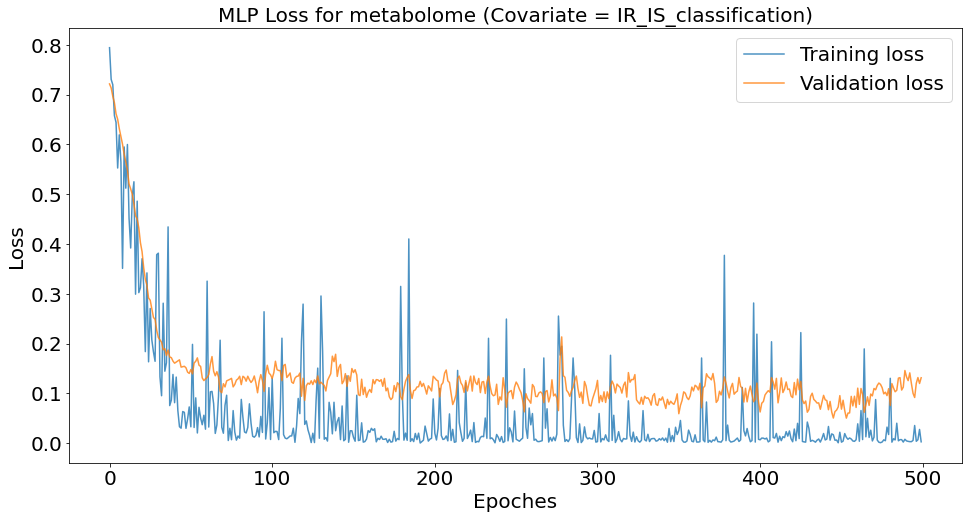

In [13]:
plot_mlp_loss(hist_m_iris, 'IR_IS_classification', 'metabolome', random_seed=456)

### 2) Sex

In [14]:
classifier_g_sex, optimizer_g_sex, hist_g_sex, index_set_sex, le_sex = train_mlp('Sex', 'gut_16s', random_seed=456)

Epoch 0 	train_loss	0.7184028029441833	val_loss	0.6781435012817383
Epoch 1 	train_loss	0.7206505537033081	val_loss	0.6732128262519836
Epoch 2 	train_loss	0.7445783615112305	val_loss	0.6698365807533264
Epoch 3 	train_loss	0.7142196893692017	val_loss	0.6696344017982483
Epoch 4 	train_loss	0.6845976114273071	val_loss	0.6666801571846008
Epoch 5 	train_loss	0.7012691497802734	val_loss	0.6653221249580383
Epoch 6 	train_loss	0.6517146825790405	val_loss	0.6669919490814209
Epoch 7 	train_loss	0.702989399433136	val_loss	0.6674184203147888
Epoch 8 	train_loss	0.6651056408882141	val_loss	0.6658423542976379
Epoch 9 	train_loss	0.6859022974967957	val_loss	0.6690464019775391
Epoch 10 	train_loss	0.7036051750183105	val_loss	0.6654866337776184
Epoch 11 	train_loss	0.6435484290122986	val_loss	0.6661942601203918
Epoch 12 	train_loss	0.6662651300430298	val_loss	0.6687324047088623
Epoch 13 	train_loss	0.6502996683120728	val_loss	0.6649307608604431
Epoch 14 	train_loss	0.6733607649803162	val_loss	0.66557878

Epoch 121 	train_loss	0.5545399785041809	val_loss	0.5324850082397461
Epoch 122 	train_loss	0.5615609884262085	val_loss	0.5318530201911926
Epoch 123 	train_loss	0.504509449005127	val_loss	0.5276270508766174
Epoch 124 	train_loss	0.546097993850708	val_loss	0.52695631980896
Epoch 125 	train_loss	0.5965951085090637	val_loss	0.5216705799102783
Epoch 126 	train_loss	0.5795177221298218	val_loss	0.5190258026123047
Epoch 127 	train_loss	0.5080979466438293	val_loss	0.5188636183738708
Epoch 128 	train_loss	0.5443072319030762	val_loss	0.5166927576065063
Epoch 129 	train_loss	0.49055907130241394	val_loss	0.5440281629562378
Epoch 130 	train_loss	0.6932419538497925	val_loss	0.5381675362586975
Epoch 131 	train_loss	0.5045972466468811	val_loss	0.5449532270431519
Epoch 132 	train_loss	0.5260913968086243	val_loss	0.5541132688522339
Epoch 133 	train_loss	0.5251051783561707	val_loss	0.5453501343727112
Epoch 134 	train_loss	0.5585144758224487	val_loss	0.5182785987854004
Epoch 135 	train_loss	0.4759891927242

Epoch 241 	train_loss	0.35335439443588257	val_loss	0.4277293384075165
Epoch 242 	train_loss	0.47807881236076355	val_loss	0.45720377564430237
Epoch 243 	train_loss	0.38247403502464294	val_loss	0.4998281002044678
Epoch 244 	train_loss	0.41403576731681824	val_loss	0.46799978613853455
Epoch 245 	train_loss	0.5488482713699341	val_loss	0.5014597177505493
Epoch 246 	train_loss	0.4494945704936981	val_loss	0.49390673637390137
Epoch 247 	train_loss	0.3909420669078827	val_loss	0.5096814036369324
Epoch 248 	train_loss	0.441824346780777	val_loss	0.5219208598136902
Epoch 249 	train_loss	0.3039775788784027	val_loss	0.5324217677116394
Epoch 250 	train_loss	0.3589928150177002	val_loss	0.5175359845161438
Epoch 251 	train_loss	0.29515329003334045	val_loss	0.48926910758018494
Epoch 252 	train_loss	0.2886669337749481	val_loss	0.48909974098205566
Epoch 253 	train_loss	0.26270702481269836	val_loss	0.4682927131652832
Epoch 254 	train_loss	0.37174779176712036	val_loss	0.45838484168052673
Epoch 255 	train_loss	

Epoch 361 	train_loss	0.4177749454975128	val_loss	0.4974247217178345
Epoch 362 	train_loss	0.3263847529888153	val_loss	0.4886448383331299
Epoch 363 	train_loss	0.27633413672447205	val_loss	0.41974249482154846
Epoch 364 	train_loss	0.43757471442222595	val_loss	0.4673598110675812
Epoch 365 	train_loss	0.272588312625885	val_loss	0.4418086111545563
Epoch 366 	train_loss	0.25532644987106323	val_loss	0.4397723376750946
Epoch 367 	train_loss	0.3584015965461731	val_loss	0.42663970589637756
Epoch 368 	train_loss	0.34286656975746155	val_loss	0.5143067836761475
Epoch 369 	train_loss	0.3765288293361664	val_loss	0.4995907247066498
Epoch 370 	train_loss	0.3013577163219452	val_loss	0.444154292345047
Epoch 371 	train_loss	0.3544566333293915	val_loss	0.4407767057418823
Epoch 372 	train_loss	0.4415992796421051	val_loss	0.42805513739585876
Epoch 373 	train_loss	0.31480368971824646	val_loss	0.4362039566040039
Epoch 374 	train_loss	0.24133522808551788	val_loss	0.47701987624168396
Epoch 375 	train_loss	0.20

Epoch 481 	train_loss	0.26579493284225464	val_loss	0.480872243642807
Epoch 482 	train_loss	0.135920912027359	val_loss	0.4475307762622833
Epoch 483 	train_loss	0.44384679198265076	val_loss	0.5432237982749939
Epoch 484 	train_loss	0.21755217015743256	val_loss	0.5936289429664612
Epoch 485 	train_loss	0.16283757984638214	val_loss	0.5600183010101318
Epoch 486 	train_loss	0.0756513699889183	val_loss	0.5355420112609863
Epoch 487 	train_loss	0.3217697739601135	val_loss	0.5555068850517273
Epoch 488 	train_loss	0.29505398869514465	val_loss	0.5660212635993958
Epoch 489 	train_loss	0.14189600944519043	val_loss	0.6180872321128845
Epoch 490 	train_loss	0.3962607979774475	val_loss	0.5741688013076782
Epoch 491 	train_loss	0.21005718410015106	val_loss	0.5015578269958496
Epoch 492 	train_loss	0.433057576417923	val_loss	0.534710168838501
Epoch 493 	train_loss	0.4434795677661896	val_loss	0.4585717022418976
Epoch 494 	train_loss	0.19099733233451843	val_loss	0.5744661092758179
Epoch 495 	train_loss	0.248652

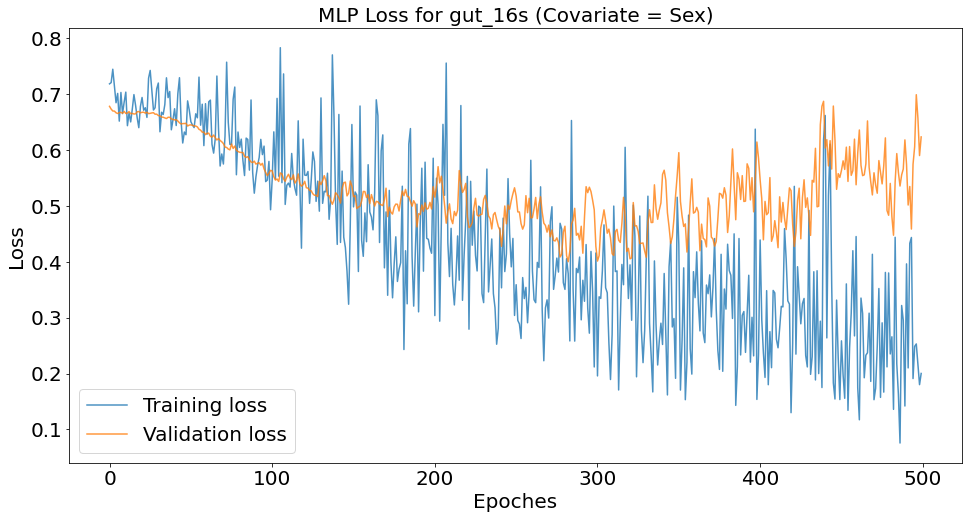

In [15]:
plot_mlp_loss(hist_g_sex, 'Sex', 'gut_16s', random_seed=456)

In [16]:
classifier_m_sex, optimizer_m_sex, hist_m_sex, index_set_sex, le_sex = train_mlp('Sex', 'metabolome', random_seed=456)

Epoch 0 	train_loss	0.6737117767333984	val_loss	0.673865556716919
Epoch 1 	train_loss	0.6940556764602661	val_loss	0.653569757938385
Epoch 2 	train_loss	0.5852364897727966	val_loss	0.6240204572677612
Epoch 3 	train_loss	0.6840248703956604	val_loss	0.5978350043296814
Epoch 4 	train_loss	0.5465901494026184	val_loss	0.5719819664955139
Epoch 5 	train_loss	0.5567643046379089	val_loss	0.5481141209602356
Epoch 6 	train_loss	0.44209617376327515	val_loss	0.5221266150474548
Epoch 7 	train_loss	0.43473243713378906	val_loss	0.4985811412334442
Epoch 8 	train_loss	0.4680109918117523	val_loss	0.4710609018802643
Epoch 9 	train_loss	0.3708198666572571	val_loss	0.45698049664497375
Epoch 10 	train_loss	0.36934763193130493	val_loss	0.4415431022644043
Epoch 11 	train_loss	0.31119823455810547	val_loss	0.41741645336151123
Epoch 12 	train_loss	0.29045936465263367	val_loss	0.3959817886352539
Epoch 13 	train_loss	0.2939671576023102	val_loss	0.3715444803237915
Epoch 14 	train_loss	0.27707430720329285	val_loss	0.3

Epoch 121 	train_loss	0.014051778241991997	val_loss	0.17117337882518768
Epoch 122 	train_loss	0.0191420279443264	val_loss	0.1779860109090805
Epoch 123 	train_loss	0.01377945113927126	val_loss	0.15862786769866943
Epoch 124 	train_loss	0.01355891115963459	val_loss	0.15523017942905426
Epoch 125 	train_loss	0.004674482624977827	val_loss	0.14499159157276154
Epoch 126 	train_loss	0.004697815515100956	val_loss	0.1984981745481491
Epoch 127 	train_loss	0.012967684306204319	val_loss	0.17668680846691132
Epoch 128 	train_loss	0.002423996804282069	val_loss	0.18998634815216064
Epoch 129 	train_loss	0.04279320314526558	val_loss	0.21265308558940887
Epoch 130 	train_loss	0.025488603860139847	val_loss	0.16866348683834076
Epoch 131 	train_loss	0.004340660758316517	val_loss	0.21778671443462372
Epoch 132 	train_loss	0.027826184406876564	val_loss	0.20837517082691193
Epoch 133 	train_loss	0.011999271810054779	val_loss	0.20293934643268585
Epoch 134 	train_loss	0.003396259853616357	val_loss	0.2175418585538864


Epoch 239 	train_loss	0.012646512128412724	val_loss	0.21489621698856354
Epoch 240 	train_loss	0.007590219844132662	val_loss	0.1972566694021225
Epoch 241 	train_loss	0.026997694745659828	val_loss	0.1937887817621231
Epoch 242 	train_loss	0.005500734318047762	val_loss	0.18429267406463623
Epoch 243 	train_loss	0.003312953282147646	val_loss	0.16390179097652435
Epoch 244 	train_loss	0.006611531134694815	val_loss	0.18289263546466827
Epoch 245 	train_loss	0.00550123443827033	val_loss	0.15764300525188446
Epoch 246 	train_loss	0.04542725905776024	val_loss	0.17347489297389984
Epoch 247 	train_loss	0.004226855468004942	val_loss	0.1762155145406723
Epoch 248 	train_loss	0.004560285247862339	val_loss	0.1873863786458969
Epoch 249 	train_loss	0.004089492838829756	val_loss	0.18067419528961182
Epoch 250 	train_loss	0.002224474446848035	val_loss	0.16645865142345428
Epoch 251 	train_loss	0.011600908823311329	val_loss	0.16747112572193146
Epoch 252 	train_loss	0.0038405410014092922	val_loss	0.157073035836219

Epoch 356 	train_loss	0.004622097127139568	val_loss	0.14761003851890564
Epoch 357 	train_loss	0.022314297035336494	val_loss	0.12776480615139008
Epoch 358 	train_loss	0.0059579419903457165	val_loss	0.13572101294994354
Epoch 359 	train_loss	0.009904222562909126	val_loss	0.1287594586610794
Epoch 360 	train_loss	0.007246336899697781	val_loss	0.1612822264432907
Epoch 361 	train_loss	0.003840027377009392	val_loss	0.14258794486522675
Epoch 362 	train_loss	0.006648443639278412	val_loss	0.1534954011440277
Epoch 363 	train_loss	0.0051728649996221066	val_loss	0.13693712651729584
Epoch 364 	train_loss	0.010749182663857937	val_loss	0.1205497607588768
Epoch 365 	train_loss	0.024724630638957024	val_loss	0.12809565663337708
Epoch 366 	train_loss	0.004085634835064411	val_loss	0.1148441955447197
Epoch 367 	train_loss	0.005731130484491587	val_loss	0.1092473566532135
Epoch 368 	train_loss	0.008583711460232735	val_loss	0.11736509948968887
Epoch 369 	train_loss	0.0027403912972658873	val_loss	0.1193180382251

Epoch 474 	train_loss	0.01207041461020708	val_loss	0.11659926176071167
Epoch 475 	train_loss	0.007871804758906364	val_loss	0.11088767647743225
Epoch 476 	train_loss	0.003017065580934286	val_loss	0.10984896868467331
Epoch 477 	train_loss	0.006110504735261202	val_loss	0.12480446696281433
Epoch 478 	train_loss	0.007017225492745638	val_loss	0.1257130354642868
Epoch 479 	train_loss	0.008250540122389793	val_loss	0.11291461437940598
Epoch 480 	train_loss	0.011667899787425995	val_loss	0.10779603570699692
Epoch 481 	train_loss	0.02513364888727665	val_loss	0.10568812489509583
Epoch 482 	train_loss	0.007072261534631252	val_loss	0.13478107750415802
Epoch 483 	train_loss	0.004954771138727665	val_loss	0.1243618056178093
Epoch 484 	train_loss	0.002222440205514431	val_loss	0.12396564334630966
Epoch 485 	train_loss	0.0026647502090781927	val_loss	0.10322314500808716
Epoch 486 	train_loss	0.007911130785942078	val_loss	0.1349317729473114
Epoch 487 	train_loss	0.006081168074160814	val_loss	0.12350643426179

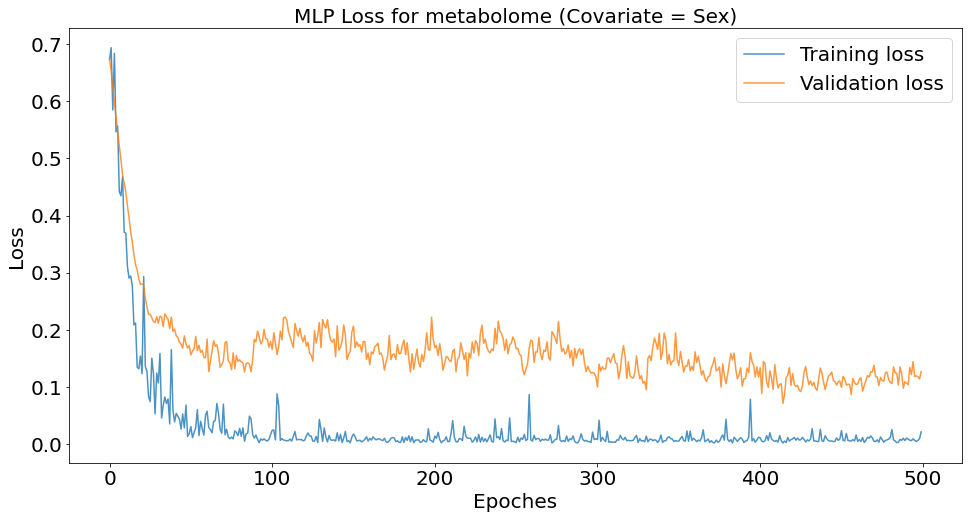

In [17]:
plot_mlp_loss(hist_m_sex, 'Sex', 'metabolome', random_seed=456)

### 3) Race

In [18]:
classifier_g_race, optimizer_g_race, hist_g_race, index_set_race, le_race = train_mlp('Race', 'gut_16s', random_seed=456)

Epoch 0 	train_loss	1.311359167098999	val_loss	1.4281394481658936
Epoch 1 	train_loss	1.394249439239502	val_loss	1.3737397193908691
Epoch 2 	train_loss	1.2755868434906006	val_loss	1.355363368988037
Epoch 3 	train_loss	1.4462507963180542	val_loss	1.3034648895263672
Epoch 4 	train_loss	1.0850281715393066	val_loss	1.2573641538619995
Epoch 5 	train_loss	1.0894620418548584	val_loss	1.2359768152236938
Epoch 6 	train_loss	1.2369098663330078	val_loss	1.2317569255828857
Epoch 7 	train_loss	1.3525694608688354	val_loss	1.2211849689483643
Epoch 8 	train_loss	1.0646522045135498	val_loss	1.1991602182388306
Epoch 9 	train_loss	1.0800471305847168	val_loss	1.2090977430343628
Epoch 10 	train_loss	0.9919571280479431	val_loss	1.2085232734680176
Epoch 11 	train_loss	0.7860009074211121	val_loss	1.199385404586792
Epoch 12 	train_loss	1.0144217014312744	val_loss	1.2086464166641235
Epoch 13 	train_loss	1.1304506063461304	val_loss	1.162964940071106
Epoch 14 	train_loss	1.0839513540267944	val_loss	1.209568500518

Epoch 122 	train_loss	0.7638942003250122	val_loss	1.1371240615844727
Epoch 123 	train_loss	0.17486435174942017	val_loss	1.3278158903121948
Epoch 124 	train_loss	1.0572986602783203	val_loss	1.1626735925674438
Epoch 125 	train_loss	0.10642324388027191	val_loss	1.1375876665115356
Epoch 126 	train_loss	0.15614090859889984	val_loss	1.1915749311447144
Epoch 127 	train_loss	1.177346110343933	val_loss	1.1324039697647095
Epoch 128 	train_loss	0.6932674646377563	val_loss	1.3212064504623413
Epoch 129 	train_loss	0.22111432254314423	val_loss	1.2845340967178345
Epoch 130 	train_loss	0.13591806590557098	val_loss	1.4135347604751587
Epoch 131 	train_loss	0.16621528565883636	val_loss	1.2338621616363525
Epoch 132 	train_loss	1.0307832956314087	val_loss	1.381466031074524
Epoch 133 	train_loss	0.4364130198955536	val_loss	1.4193874597549438
Epoch 134 	train_loss	0.8742427229881287	val_loss	1.3875470161437988
Epoch 135 	train_loss	0.8371829390525818	val_loss	1.3088316917419434
Epoch 136 	train_loss	0.190981

Epoch 242 	train_loss	0.22410137951374054	val_loss	1.4851887226104736
Epoch 243 	train_loss	0.21011905372142792	val_loss	1.4152928590774536
Epoch 244 	train_loss	0.2602328360080719	val_loss	1.30641508102417
Epoch 245 	train_loss	1.189329743385315	val_loss	1.5084141492843628
Epoch 246 	train_loss	0.19127336144447327	val_loss	1.4041039943695068
Epoch 247 	train_loss	0.22287976741790771	val_loss	1.468537449836731
Epoch 248 	train_loss	0.7890952229499817	val_loss	1.556243896484375
Epoch 249 	train_loss	0.2142830640077591	val_loss	1.5232555866241455
Epoch 250 	train_loss	0.1606634110212326	val_loss	1.5822163820266724
Epoch 251 	train_loss	0.5046942234039307	val_loss	1.5236796140670776
Epoch 252 	train_loss	0.6923060417175293	val_loss	1.749029278755188
Epoch 253 	train_loss	0.20976535975933075	val_loss	1.5689889192581177
Epoch 254 	train_loss	0.39729130268096924	val_loss	1.5967795848846436
Epoch 255 	train_loss	0.7842246294021606	val_loss	1.784429907798767
Epoch 256 	train_loss	2.08824348449

Epoch 362 	train_loss	0.24992932379245758	val_loss	1.693537950515747
Epoch 363 	train_loss	0.40279215574264526	val_loss	1.7256348133087158
Epoch 364 	train_loss	0.06403074413537979	val_loss	1.826137900352478
Epoch 365 	train_loss	0.4246213734149933	val_loss	1.6606712341308594
Epoch 366 	train_loss	0.4374697804450989	val_loss	1.539739966392517
Epoch 367 	train_loss	0.10079813003540039	val_loss	1.575516939163208
Epoch 368 	train_loss	1.2007417678833008	val_loss	1.7171393632888794
Epoch 369 	train_loss	0.5582563877105713	val_loss	1.8774739503860474
Epoch 370 	train_loss	0.3070051074028015	val_loss	1.7535072565078735
Epoch 371 	train_loss	0.21168439090251923	val_loss	1.6325560808181763
Epoch 372 	train_loss	0.8239490985870361	val_loss	1.7719954252243042
Epoch 373 	train_loss	0.05948294326663017	val_loss	1.8551597595214844
Epoch 374 	train_loss	0.33034008741378784	val_loss	2.067856550216675
Epoch 375 	train_loss	0.3351157307624817	val_loss	1.8850888013839722
Epoch 376 	train_loss	0.19639486

Epoch 482 	train_loss	0.43071070313453674	val_loss	1.7110424041748047
Epoch 483 	train_loss	0.6803472638130188	val_loss	1.7222591638565063
Epoch 484 	train_loss	0.08048223704099655	val_loss	1.5871654748916626
Epoch 485 	train_loss	0.6391003131866455	val_loss	1.6891887187957764
Epoch 486 	train_loss	0.2849980890750885	val_loss	1.6489440202713013
Epoch 487 	train_loss	1.325640320777893	val_loss	1.7399849891662598
Epoch 488 	train_loss	0.6255013942718506	val_loss	1.4846768379211426
Epoch 489 	train_loss	0.32330748438835144	val_loss	1.5457390546798706
Epoch 490 	train_loss	0.0472068190574646	val_loss	1.562557339668274
Epoch 491 	train_loss	0.4626324474811554	val_loss	1.7752375602722168
Epoch 492 	train_loss	0.5033202171325684	val_loss	1.981889009475708
Epoch 493 	train_loss	2.0896434783935547	val_loss	2.1379241943359375
Epoch 494 	train_loss	0.6235931515693665	val_loss	2.0006864070892334
Epoch 495 	train_loss	0.614560067653656	val_loss	2.021101474761963
Epoch 496 	train_loss	0.649387121200

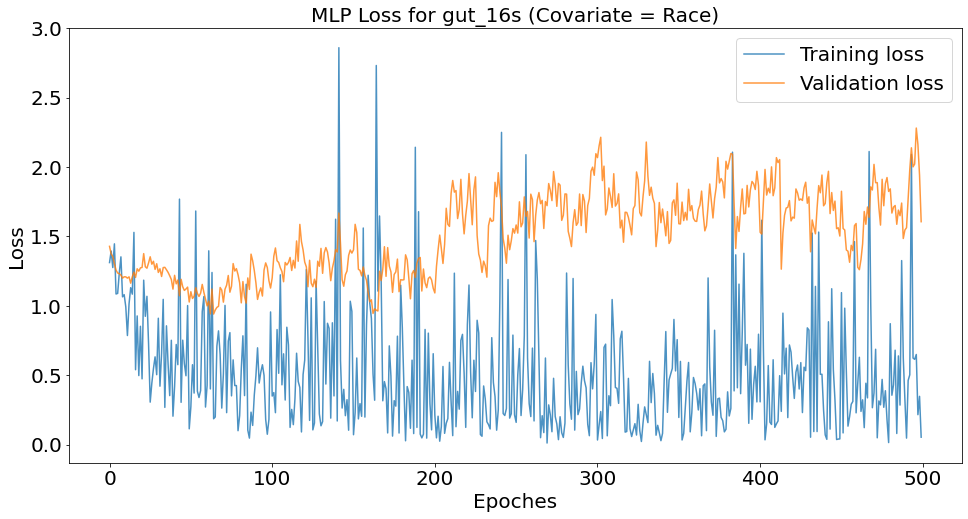

In [19]:
plot_mlp_loss(hist_g_race, 'Race', 'gut_16s', random_seed=456)

In [20]:
classifier_m_race, optimizer_m_race, hist_m_race, index_set_race, le_race = train_mlp('Race', 'metabolome', random_seed=456)

Epoch 0 	train_loss	1.2582557201385498	val_loss	1.176358938217163
Epoch 1 	train_loss	0.8571295738220215	val_loss	1.0723706483840942
Epoch 2 	train_loss	0.9774405360221863	val_loss	0.9620845317840576
Epoch 3 	train_loss	0.8891258835792542	val_loss	0.812103271484375
Epoch 4 	train_loss	0.7362942099571228	val_loss	0.6478002071380615
Epoch 5 	train_loss	0.31306353211402893	val_loss	0.5202224254608154
Epoch 6 	train_loss	0.21310290694236755	val_loss	0.38253259658813477
Epoch 7 	train_loss	0.322949081659317	val_loss	0.32911017537117004
Epoch 8 	train_loss	0.1058855950832367	val_loss	0.25841596722602844
Epoch 9 	train_loss	0.3700461685657501	val_loss	0.23901939392089844
Epoch 10 	train_loss	0.47965723276138306	val_loss	0.18534035980701447
Epoch 11 	train_loss	0.12378588318824768	val_loss	0.21951346099376678
Epoch 12 	train_loss	0.03122893162071705	val_loss	0.19870682060718536
Epoch 13 	train_loss	0.07501164823770523	val_loss	0.17833131551742554
Epoch 14 	train_loss	0.234129399061203	val_loss

Epoch 118 	train_loss	0.05797232687473297	val_loss	0.032118283212184906
Epoch 119 	train_loss	0.009405802935361862	val_loss	0.03584671393036842
Epoch 120 	train_loss	0.08145936578512192	val_loss	0.0364910364151001
Epoch 121 	train_loss	0.017010709270834923	val_loss	0.0355047732591629
Epoch 122 	train_loss	0.0075250775553286076	val_loss	0.044833842664957047
Epoch 123 	train_loss	0.28919699788093567	val_loss	0.033141180872917175
Epoch 124 	train_loss	0.004349257797002792	val_loss	0.02473912388086319
Epoch 125 	train_loss	0.019809838384389877	val_loss	0.028664303943514824
Epoch 126 	train_loss	0.014871045015752316	val_loss	0.03556844964623451
Epoch 127 	train_loss	0.010920006781816483	val_loss	0.03319834917783737
Epoch 128 	train_loss	0.11387823522090912	val_loss	0.03970012813806534
Epoch 129 	train_loss	0.023310275748372078	val_loss	0.034317564219236374
Epoch 130 	train_loss	0.08608593046665192	val_loss	0.03344114124774933
Epoch 131 	train_loss	0.020756592974066734	val_loss	0.02935359627

Epoch 234 	train_loss	0.013778496533632278	val_loss	0.052643466740846634
Epoch 235 	train_loss	0.0154058076441288	val_loss	0.039376400411129
Epoch 236 	train_loss	0.012356743216514587	val_loss	0.045861516147851944
Epoch 237 	train_loss	0.15150147676467896	val_loss	0.04179283604025841
Epoch 238 	train_loss	0.010819150134921074	val_loss	0.04719526693224907
Epoch 239 	train_loss	0.4562268853187561	val_loss	0.04250442609190941
Epoch 240 	train_loss	0.05080052837729454	val_loss	0.03369615599513054
Epoch 241 	train_loss	0.015366855077445507	val_loss	0.03753644973039627
Epoch 242 	train_loss	0.07714597880840302	val_loss	0.04065610095858574
Epoch 243 	train_loss	0.04779747501015663	val_loss	0.03727312758564949
Epoch 244 	train_loss	0.015139039605855942	val_loss	0.04036468639969826
Epoch 245 	train_loss	0.8797303438186646	val_loss	0.040089260786771774
Epoch 246 	train_loss	0.006974403280764818	val_loss	0.04078539088368416
Epoch 247 	train_loss	0.16897191107273102	val_loss	0.041781362146139145
E

Epoch 350 	train_loss	0.007726416923105717	val_loss	0.06096118316054344
Epoch 351 	train_loss	0.1149987205862999	val_loss	0.0579601489007473
Epoch 352 	train_loss	0.035077378153800964	val_loss	0.05570562928915024
Epoch 353 	train_loss	0.06178874149918556	val_loss	0.057463955134153366
Epoch 354 	train_loss	0.017171025276184082	val_loss	0.050697196274995804
Epoch 355 	train_loss	0.007511730305850506	val_loss	0.046618521213531494
Epoch 356 	train_loss	0.010028345510363579	val_loss	0.05403049290180206
Epoch 357 	train_loss	0.01729109138250351	val_loss	0.05518525466322899
Epoch 358 	train_loss	0.051918841898441315	val_loss	0.0522623285651207
Epoch 359 	train_loss	0.013973909430205822	val_loss	0.04547302797436714
Epoch 360 	train_loss	0.28526780009269714	val_loss	0.07623352110385895
Epoch 361 	train_loss	0.27223876118659973	val_loss	0.07014629244804382
Epoch 362 	train_loss	0.42476561665534973	val_loss	0.0874851644039154
Epoch 363 	train_loss	0.028994526714086533	val_loss	0.09520625323057175

Epoch 466 	train_loss	0.009159510023891926	val_loss	0.032928500324487686
Epoch 467 	train_loss	0.05381591618061066	val_loss	0.025216849520802498
Epoch 468 	train_loss	0.04244912788271904	val_loss	0.030880721285939217
Epoch 469 	train_loss	0.007595755625516176	val_loss	0.025562124326825142
Epoch 470 	train_loss	0.01374523714184761	val_loss	0.030406789854168892
Epoch 471 	train_loss	0.13361740112304688	val_loss	0.02651362493634224
Epoch 472 	train_loss	0.6457806825637817	val_loss	0.03843357414007187
Epoch 473 	train_loss	0.1189933493733406	val_loss	0.05138946697115898
Epoch 474 	train_loss	0.026172012090682983	val_loss	0.02554761804640293
Epoch 475 	train_loss	0.0493486225605011	val_loss	0.026429809629917145
Epoch 476 	train_loss	0.006024045869708061	val_loss	0.03326183930039406
Epoch 477 	train_loss	0.02326691523194313	val_loss	0.02217508666217327
Epoch 478 	train_loss	0.01772533729672432	val_loss	0.022887496277689934
Epoch 479 	train_loss	0.04278300702571869	val_loss	0.0229167062789201

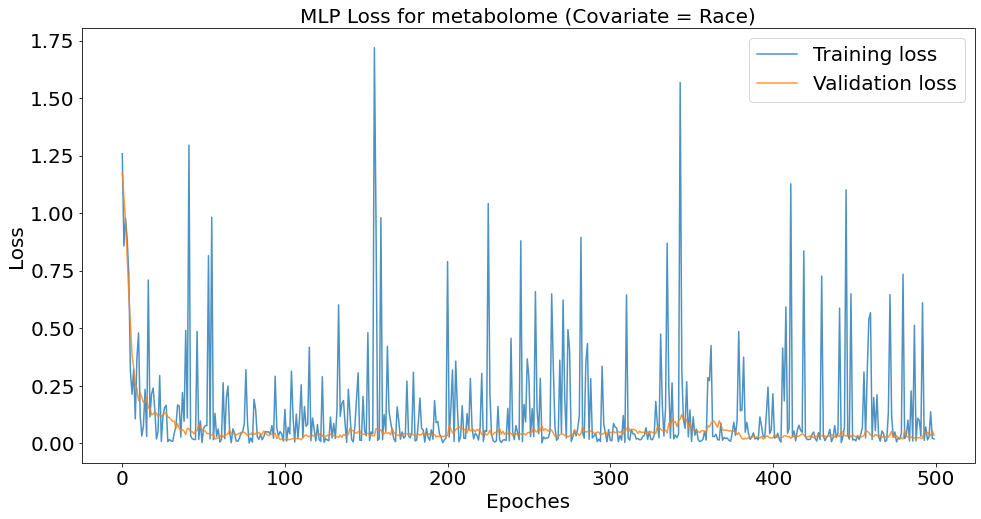

In [21]:
plot_mlp_loss(hist_m_race, 'Race', 'metabolome', random_seed=456)

## Prediction

In [22]:
def predict_mlp(covariate, gm_data_name, classifier_g, classifier_m, le):
    
    gut_16s_feat_subj_val = pd.read_pickle('./feature_data/{}/val/gut_16s_feat_subj_val.pkl'.format(covariate))
    metabolome_feat_subj_val = pd.read_pickle('./feature_data/{}/val/metabolome_feat_subj_val.pkl'.format(covariate))

    gut_16s_feat_subj_test = pd.read_pickle('./feature_data/{}/test/gut_16s_feat_subj_test.pkl'.format(covariate))
    metabolome_feat_subj_test = pd.read_pickle('./feature_data/{}/test/metabolome_feat_subj_test.pkl'.format(covariate))
    
    indexes_val = gut_16s_feat_subj_val.index
    indexes_test = gut_16s_feat_subj_test.index
    
    X_val_g = np.array(gut_16s_df.loc[indexes_val,:])
    y_val_g = gut_16s_feat_subj_val.loc[:,covariate].values
    X_test_g = np.array(gut_16s_df.loc[indexes_test,:])
    y_test_g = gut_16s_feat_subj_test.loc[:,covariate].values

    X_val_m = np.array(metabolome_df.loc[indexes_val,:])
    y_val_m = metabolome_feat_subj_val.loc[:,covariate].values
    X_test_m = np.array(metabolome_df.loc[indexes_test,:])
    y_test_m = metabolome_feat_subj_test.loc[:,covariate].values
    
    if gm_data_name=='gut_16s':
        X_val, X_test, y_val, y_test = X_val_g, X_test_g, y_val_g, y_test_g
        classifier = classifier_g
    
    elif gm_data_name=='metabolome':
        X_val, X_test, y_val, y_test = X_val_m, X_test_m, y_val_m, y_test_m
        classifier = classifier_m
    
    classes = le.classes_
    
    classifier.eval()
    with torch.no_grad():
        prediction_val = classifier(torch.tensor(np.array(X_val, dtype='float32')).to(device)).cpu().numpy()
        prediction_test = classifier(torch.tensor(np.array(X_test, dtype='float32')).to(device)).cpu().numpy()
    pred_class_val = classes[nn.Softmax(dim=1)(torch.tensor(prediction_val)).argmax(axis=1)]
    pred_class_test = classes[nn.Softmax(dim=1)(torch.tensor(prediction_test)).argmax(axis=1)]
    accuracy_val = sum(pred_class_val==y_val)/len(pred_class_val)
    accuracy_test = sum(pred_class_test==y_test)/len(pred_class_test)
    return (prediction_val, pred_class_val, accuracy_val), (prediction_test, pred_class_test, accuracy_test)

### 1) IR_IS_classification

In [23]:
(prediction_val_g_iris, pred_class_val_g_iris, accuracy_val_g_iris), \
(prediction_test_g_iris, pred_class_test_g_iris, accuracy_test_g_iris) = \
    predict_mlp('IR_IS_classification', 'gut_16s', classifier_g_iris, classifier_m_iris, le_iris)


In [24]:
(prediction_val_m_iris, pred_class_val_m_iris, accuracy_val_m_iris), \
(prediction_test_m_iris, pred_class_test_m_iris, accuracy_test_m_iris) = \
    predict_mlp('IR_IS_classification', 'metabolome', classifier_g_iris, classifier_m_iris, le_iris)

In [25]:
print('Validation:\nPrediction accuracy for microbiome embedding (MLP; {0}) = {1:.2%}\n'
      'Prediction accuracy for metabolome embedding (MLP; {0}) = {2:.2%}\n\n'
      'Testing:\nPrediction accuracy for microbiome embedding (MLP; {0}) = {3:.2%}\n'
      'Prediction accuracy for metabolome embedding (MLP; {0}) = {4:.2%}'.\
      format('IR_IS_classification', accuracy_val_g_iris, accuracy_val_m_iris, accuracy_test_g_iris, accuracy_test_m_iris))

Validation:
Prediction accuracy for microbiome embedding (MLP; IR_IS_classification) = 84.15%
Prediction accuracy for metabolome embedding (MLP; IR_IS_classification) = 95.12%

Testing:
Prediction accuracy for microbiome embedding (MLP; IR_IS_classification) = 79.52%
Prediction accuracy for metabolome embedding (MLP; IR_IS_classification) = 93.98%


### 2) Sex

In [26]:
(prediction_val_g_sex, pred_class_val_g_sex, accuracy_val_g_sex), \
(prediction_test_g_sex, pred_class_test_g_sex, accuracy_test_g_sex) = \
    predict_mlp('Sex', 'gut_16s', classifier_g_sex, classifier_m_sex, le_sex)


In [27]:
(prediction_val_m_sex, pred_class_val_m_sex, accuracy_val_m_sex), \
(prediction_test_m_sex, pred_class_test_m_sex, accuracy_test_m_sex) = \
    predict_mlp('Sex', 'metabolome', classifier_g_sex, classifier_m_sex, le_sex)

In [28]:
print('Validation:\nPrediction accuracy for microbiome embedding (MLP; {0}) = {1:.2%}\n'
      'Prediction accuracy for metabolome embedding (MLP; {0}) = {2:.2%}\n\n'
      'Testing:\nPrediction accuracy for microbiome embedding (MLP; {0}) = {3:.2%}\n'
      'Prediction accuracy for metabolome embedding (MLP; {0}) = {4:.2%}'.\
      format('Sex', accuracy_val_g_sex, accuracy_val_m_sex, accuracy_test_g_sex, accuracy_test_m_sex))

Validation:
Prediction accuracy for microbiome embedding (MLP; Sex) = 79.63%
Prediction accuracy for metabolome embedding (MLP; Sex) = 97.22%

Testing:
Prediction accuracy for microbiome embedding (MLP; Sex) = 80.73%
Prediction accuracy for metabolome embedding (MLP; Sex) = 97.25%


### 3) Race

In [29]:
(prediction_val_g_race, pred_class_val_g_race, accuracy_val_g_race), \
(prediction_test_g_race, pred_class_test_g_race, accuracy_test_g_race) = \
    predict_mlp('Race', 'gut_16s', classifier_g_race, classifier_m_race, le_race)


In [30]:
(prediction_val_m_race, pred_class_val_m_race, accuracy_val_m_race), \
(prediction_test_m_race, pred_class_test_m_race, accuracy_test_m_race) = \
    predict_mlp('Race', 'metabolome', classifier_g_race, classifier_m_race, le_race)

In [31]:
print('Validation:\nPrediction accuracy for microbiome embedding (MLP; {0}) = {1:.2%}\n'
      'Prediction accuracy for metabolome embedding (MLP; {0}) = {2:.2%}\n\n'
      'Testing:\nPrediction accuracy for microbiome embedding (MLP; {0}) = {3:.2%}\n'
      'Prediction accuracy for metabolome embedding (MLP; {0}) = {4:.2%}'.\
      format('Race', accuracy_val_g_race, accuracy_val_m_race, accuracy_test_g_race, accuracy_test_m_race))

Validation:
Prediction accuracy for microbiome embedding (MLP; Race) = 75.70%
Prediction accuracy for metabolome embedding (MLP; Race) = 97.20%

Testing:
Prediction accuracy for microbiome embedding (MLP; Race) = 77.06%
Prediction accuracy for metabolome embedding (MLP; Race) = 96.33%
